# Dataset Information
The objective of this task is to detect emotion in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racisst or sexixst sentiment associated with it.

In [4]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from keras.layers import *
from keras.models import *
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
data = pd.read_csv('Covid_19_training.csv', engine ='python')
data.columns =["ID","Tweet","labels"]

In [6]:
data.head()

,ID,Tweet,labels
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10
1,2,BanMediaHouse whose is responsible for spreadi...,6
2,3,Im waiting for someone to say to me that all t...,3 4
3,4,He is a liar. Proven day night. Time again. Li...,6
4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",8


In [7]:
data.tail()

,ID,Tweet,labels
4995,4996,Life Insurance? I wonder if policies are payin...,4 5 7
4996,4997,My cousin passed away from the corona virus to...,4 5
4997,4998,I guess Mother Nature really hates us. Yellows...,3 5 9 10
4998,4999,So question for the day that isnt related to c...,9 10
4999,5000,"Dear corona, If you cancel my fucking church c...",6 10


In [8]:
data.columns

Index(['ID', 'Tweet', 'labels'], dtype='object')

In [9]:
print("length of data is: ",len(data))

length of data is:  5000


In [10]:
data.shape

(5000, 3)

In [11]:
data.info

<bound method DataFrame.info of         ID                                              Tweet    labels
0        1  NO JOKE I WILL HOP ON A PLANE RN! (Well after ...      0 10
1        2  BanMediaHouse whose is responsible for spreadi...         6
2        3  Im waiting for someone to say to me that all t...       3 4
3        4  He is a liar. Proven day night. Time again. Li...         6
4        5  NEW: U.S. CoronaVirus death toll reaches 4,000...         8
...    ...                                                ...       ...
4995  4996  Life Insurance? I wonder if policies are payin...     4 5 7
4996  4997  My cousin passed away from the corona virus to...       4 5
4997  4998  I guess Mother Nature really hates us. Yellows...  3 5 9 10
4998  4999  So question for the day that isnt related to c...      9 10
4999  5000  Dear corona, If you cancel my fucking church c...      6 10

[5000 rows x 3 columns]>

In [12]:
data.dtypes

ID         int64
Tweet     object
labels    object
dtype: object

# Basic preprocessing the dataset

In [13]:
def remove_pattern(input_txt,pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt =re.sub(word, "", input_txt)
    return input_txt

In [14]:
#remove twitter handle (@user)
data['clean_tweet']= np.vectorize(remove_pattern)(data['Tweet'],"@[\w]*")

In [15]:
data.head()

,ID,Tweet,labels,clean_tweet
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...
1,2,BanMediaHouse whose is responsible for spreadi...,6,BanMediaHouse whose is responsible for spreadi...
2,3,Im waiting for someone to say to me that all t...,3 4,Im waiting for someone to say to me that all t...
3,4,He is a liar. Proven day night. Time again. Li...,6,He is a liar. Proven day night. Time again. Li...
4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",8,"NEW: U.S. CoronaVirus death toll reaches 4,000..."


In [16]:
#removing special characters, numbers and punctuation
data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]"," ")
data.head()

,ID,Tweet,labels,clean_tweet
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10,NO JOKE I WILL HOP ON A PLANE RN Well after ...
1,2,BanMediaHouse whose is responsible for spreadi...,6,BanMediaHouse whose is responsible for spreadi...
2,3,Im waiting for someone to say to me that all t...,3 4,Im waiting for someone to say to me that all t...
3,4,He is a liar. Proven day night. Time again. Li...,6,He is a liar Proven day night Time again Li...
4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",8,NEW U S CoronaVirus death toll reaches ...


In [17]:
#remove short words

data['clean_tweet'] = data['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w) >3]))
data.head()

,ID,Tweet,labels,clean_tweet
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10,JOKE WILL PLANE Well after COVID
1,2,BanMediaHouse whose is responsible for spreadi...,6,BanMediaHouse whose responsible spreading Fake...
2,3,Im waiting for someone to say to me that all t...,3 4,waiting someone that this corona thing just Ap...
3,4,He is a liar. Proven day night. Time again. Li...,6,liar Proven night Time again Lies when truth w...
4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",8,CoronaVirus death toll reaches after nearly de...


In [18]:
#individual words considered as tokens
tokenized_tweet = data['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0              [JOKE, WILL, PLANE, Well, after, COVID]
1    [BanMediaHouse, whose, responsible, spreading,...
2    [waiting, someone, that, this, corona, thing, ...
3    [liar, Proven, night, Time, again, Lies, when,...
4    [CoronaVirus, death, toll, reaches, after, nea...
Name: clean_tweet, dtype: object

In [19]:
#stem the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0              [joke, will, plane, well, after, covid]
1    [banmediahous, whose, respons, spread, fake, c...
2    [wait, someon, that, thi, corona, thing, just,...
3    [liar, proven, night, time, again, lie, when, ...
4    [coronaviru, death, toll, reach, after, nearli...
Name: clean_tweet, dtype: object

In [20]:
#combine into single sentence

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i]=" ".join(tokenized_tweet[i])
    
data['clean_tweet'] = tokenized_tweet
data.head()    
    

,ID,Tweet,labels,clean_tweet
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10,joke will plane well after covid
1,2,BanMediaHouse whose is responsible for spreadi...,6,banmediahous whose respons spread fake commun ...
2,3,Im waiting for someone to say to me that all t...,3 4,wait someon that thi corona thing just april f...
3,4,He is a liar. Proven day night. Time again. Li...,6,liar proven night time again lie when truth wi...
4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",8,coronaviru death toll reach after nearli death...


# Explanory data analysis

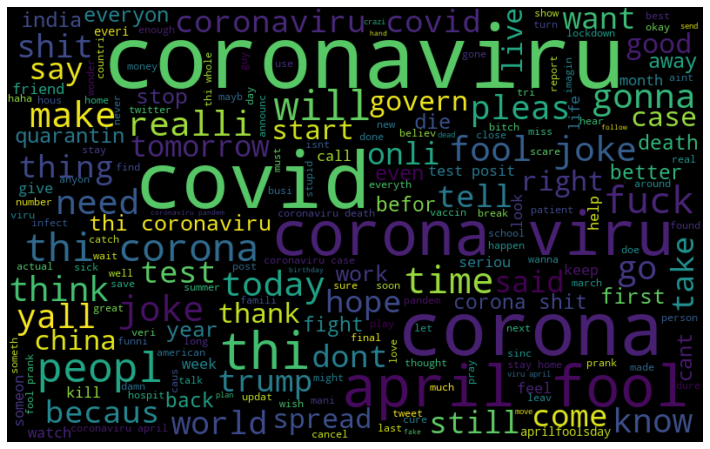

In [30]:
#visualize the frequent words

all_words=" ".join([sentence for sentence in data['clean_tweet']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation ='bilinear')
plt.axis('off')
plt.show()